In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))

In [2]:
import pandas as pd
from scripts.backtest.backtest_utils import backtest_portfolio

In [3]:
portfolio = pd.read_csv(
    "../data/processed/portfolio_hmm.csv",
    index_col=0,
    parse_dates=True
)

In [4]:
raw_perf = backtest_portfolio(portfolio.raw_returns)
scaled_perf = backtest_portfolio(portfolio.scaled_returns)

pd.DataFrame([raw_perf, scaled_perf],
             index=["Unscaled", "Regime-Scaled"])


,Annual Return,Annual Volatility,Sharpe Ratio,Max Drawdown
Unscaled,0.212525,0.214982,0.988569,-0.395288
Regime-Scaled,0.187687,0.123331,1.521808,-0.188158


/var/folders/28/dj3nmc0d5wn_x5d6qp7g64f80000gn/T/ipykernel_5170/2024992405.py:67: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  for start, end in zip(df.index[high_vol_state & (~high_vol_state.shift(1).fillna(False))],
/var/folders/28/dj3nmc0d5wn_x5d6qp7g64f80000gn/T/ipykernel_5170/2024992405.py:68: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.index[high_vol_state & (~high_vol_state.shift(-1).fillna(False))]):


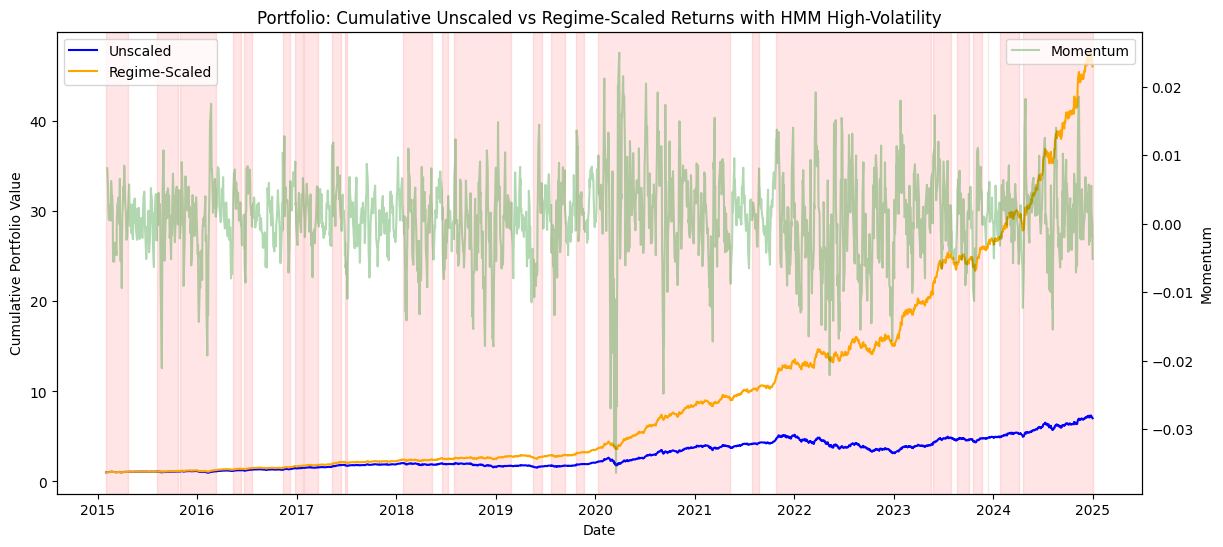

In [5]:
import os
import glob
import re
import pandas as pd
import matplotlib.pyplot as plt

def load_hmm_data(folder_path):
    """
    Load all hmm_<asset>.csv files in folder into a dictionary keyed by asset name.
    """
    pattern = re.compile(r'hmm_([A-Za-z0-9]+)')
    files = glob.glob(os.path.join(folder_path, "hmm_*.csv"))

    hmm_data = {}
    for file in files:
        filename = os.path.basename(file)
        match = pattern.match(filename)
        if match:
            asset = match.group(1)
            df = pd.read_csv(file, index_col=0)
            df.index = pd.to_datetime(df.index)  # ensure datetime index
            hmm_data[asset] = df
    return hmm_data

def construct_portfolio(hmm_data):
    """
    Compute portfolio-level raw and scaled returns (mean across assets)
    """
    raw_returns = pd.concat(
        [df[f"{asset}_ret"] for asset, df in hmm_data.items()],
        axis=1
    ).mean(axis=1)
    
    scaled_returns = pd.concat(
        [df[f"{asset}_ret"] * df['risk_scale'] for asset, df in hmm_data.items()],
        axis=1
    ).mean(axis=1)
    
    portfolio_df = pd.DataFrame({
        'raw_returns': raw_returns,
        'scaled_returns': scaled_returns
    })
    return portfolio_df

def plot_portfolio_with_hmm(portfolio_df, hmm_data, mom_window=5):
    """
    Plot cumulative portfolio returns with high-volatility shading and momentum overlay
    """
    df = portfolio_df.copy()
    df['cum_unscaled'] = (1 + df['raw_returns']).cumprod()
    df['cum_scaled'] = (1 + df['scaled_returns']).cumprod()
    df['momentum'] = df['raw_returns'].rolling(mom_window).mean()
    
    # Detect high-volatility dates: any asset in its high-vol regime
    high_vol_state = pd.Series(False, index=df.index)
    for asset, asset_df in hmm_data.items():
        high_vol_regime = asset_df.groupby("regime")[f"{asset}_vol"].mean().idxmax()
        high_vol_state |= (asset_df["regime"] == high_vol_regime)
    
    plt.figure(figsize=(14,6))
    
    # Plot cumulative returns
    plt.plot(df.index, df['cum_unscaled'], label="Unscaled", color="blue")
    plt.plot(df.index, df['cum_scaled'], label="Regime-Scaled", color="orange")
    
    # Shade high-volatility periods
    for start, end in zip(df.index[high_vol_state & (~high_vol_state.shift(1).fillna(False))],
                          df.index[high_vol_state & (~high_vol_state.shift(-1).fillna(False))]):
        plt.axvspan(start, end, color="red", alpha=0.1)
    
    # Momentum overlay
    ax1 = plt.gca()
    ax2 = ax1.twinx()
    ax2.plot(df.index, df['momentum'], label="Momentum", color="green", alpha=0.3)
    ax2.set_ylabel("Momentum")
    
    plt.title("Portfolio: Cumulative Unscaled vs Regime-Scaled Returns with HMM High-Volatility")
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Cumulative Portfolio Value")
    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")
    plt.show()

# === Usage Example ===
folder_path = "../data/processed"  # replace with your folder path
hmm_data = load_hmm_data(folder_path)
portfolio_df = construct_portfolio(hmm_data)
plot_portfolio_with_hmm(portfolio_df, hmm_data)
